In [ ]:
using Dates, DataFrames, CSV, JSON, Plots, JuMP, HiGHS, TuLiPa

In [2]:
firm_demand = 50.0
price_elasticity = -0.05
normal_price = 100.0
max_price = 150.0
min_price = 50.0
CapNucGER = 5000.0
GenNucGER = 100.0
threshold = 0.15 # threshold for approximating demand curve

elements = [
    DataElement("Balance", "BaseBalance", "PowerBalance_NO2", Dict{Any, Any}("Commodity" => "Power")),    
    DataElement("Flow", "BaseFlow", "GenNucGER", Dict{Any, Any}()),
    DataElement("Arrow", "BaseArrow", "PowerBalance_NO2", Dict{Any, Any}("Balance" => "PowerBalance_NO2", "Flow" => "GenNucGER", "Conversion" => 1.0, "Direction" => "In")),
    DataElement("Cost", "CostTerm", "MCNucGER", Dict{Any, Any}("Param" => GenNucGER, "WhichInstance" => "GenNucGER", "WhichConcept" => "Flow", "Direction" => "In")),
    DataElement("Capacity", "PositiveCapacity", "CapNucGER", Dict{Any, Any}("Param" => "CapNucGER", "WhichInstance" => "GenNucGER", "WhichConcept" => "Flow", "Bound" => "Upper")),
    DataElement("Param", "MWToGWhSeriesParam", "CapNucGER", Dict{Any, Any}("Level" => CapNucGER, "Profile" => 1.0)),
    DataElement("Param", "MeanSeriesParam", "FirmDemand", Dict{Any, Any}("Level" => firm_demand, "Profile" => 1.0)),
    
    DataElement("ElasticDemand", "BaseElasticDemand", "", 
                Dict{Any, Any}(
                    "Balance" => 
                    "PowerBalance_NO2", 
                    "Param" => "FirmDemand", 
                    "price_elasticity" => price_elasticity, 
                    "normal_price" => normal_price, 
                    "max_price" => max_price, 
                    "min_price" => min_price, 
                    "threshold" => threshold
                )
    )   
]

power_horizon = SequentialHorizon(1, Day(1))
push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Power", (HORIZON_CONCEPT, power_horizon)))
addscenariotimeperiod!(elements, "ScenarioTimePeriod", getisoyearstart(1981), getisoyearstart(1983));

In [3]:
modelobjects = getmodelobjects(elements)

Dict{Id, Any} with 3 entries:
  Id("Balance", "PowerBalance_NO2") => BaseBalance(Id("Balance", "PowerBalance_…
  Id("Flow", "GenNucGER")           => BaseFlow(Id("Flow", "GenNucGER"), Sequen…
  Id("ElasticDemand", "")           => BaseElasticDemand{BaseBalance, MeanSerie…

In [4]:
mymodel = JuMP.Model(HiGHS.Optimizer)
prob = JuMP_Prob(modelobjects, mymodel)

JuMP_Prob(A JuMP Model
Minimization problem with:
Variables: 7
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 7 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: BalancePowerBalance_NO2, ElasticDemand1, ElasticDemand2, ElasticDemand3, ElasticDemand4, ElasticDemand5, ElasticDemand6, FlowGenNucGER, Any[BaseBalance(Id("Balance", "PowerBalance_NO2"), BaseCommodity(Id("Commodity", "Power"), SequentialHorizon(SequentialPeriods([(1, Millisecond(86400000))]), nothing)), SequentialHorizon(SequentialPeriods([(1, Millisecond(86400000))]), nothing), RHSTerm[], Dict{Any, Any}()), BaseFlow(Id("Flow", "GenNucGER"), SequentialHorizon(SequentialPeriods([(1, Millisecond(86400000))]), nothing), PositiveCapacity(Id("Capacity", "CapNucGER"), MWToGWhSeriesParam{C

In [5]:
datatime = getisoyearstart(2023)
scenariotime = getisoyearstart(1981)
prob_time = TwoTime(datatime, scenariotime)
update!(prob, prob_time)
solve!(prob)

In [6]:
print(prob.model)

In [7]:
solution_summary(prob.model, verbose = true)

* Solver : HiGHS

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "kHighsModelStatusOptimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : -2.46492e+03
  Objective bound    : -2.46492e+03
  Relative gap       : Inf
  Dual objective value : -2.46492e+03
  Primal solution :
    ElasticDemand1[1] : 4.89965e+01
    ElasticDemand2[1] : 3.45838e-01
    ElasticDemand3[1] : 3.45838e-01
    ElasticDemand4[1] : 0.00000e+00
    ElasticDemand5[1] : 0.00000e+00
    ElasticDemand6[1] : 0.00000e+00
    FlowGenNucGER[1] : 4.96882e+01
  Dual solution :
    BalancePowerBalance_NO2[1] : -1.00000e+02

* Work counters
  Solve time (sec)   : 0.00000e+00
  Simplex iterations : 0
  Barrier iterations : 0
  Node count         : -1


In [8]:
ed = modelobjects[Id("ElasticDemand", "")]
println(getdemand(prob, ed, 1))

49.68821899723813


reserve_prices: [150.0, 130.31608243114442, 113.32650086738705, 85.95179939297664, 65.43586274070348, 49.99999999999993]
L: [0.9799308653125577, 0.9868476226286602, 0.9937643799447626, 1.0075978945769677, 1.0214314092091725, 1.0352649238413776]
segment_capacities: [0.9799308653125577, 0.006916757316102529, 0.006916757316102418, 0.013833514632205057, 0.013833514632204835, 0.013833514632205057]


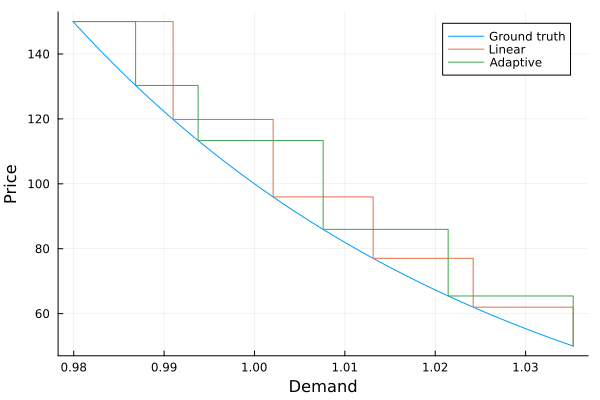

In [9]:
function visualize_demand_curve_approx()
    segment_capacities = 0
    reserve_prices = 0
    L = 0
    obj = prob.objects[findall(x -> x.id == Id("ElasticDemand", ""), prob.objects)][1]
    
    println("reserve_prices: ", obj.reserve_prices)
    println("L: ", obj.L)
    println("segment_capacities: ", obj.segment_capacities)
    
    min_p = price_to_relative_demand(obj.normal_price,obj. price_elasticity, obj.max_price)
    max_p = price_to_relative_demand(obj.normal_price, obj.price_elasticity, obj.min_price)
    linear = [i for i in range(min_p, max_p, obj.N)]
    
    ground_truth = [i for i in range(min_p, max_p, 1000)]
    reserve_prices_ground = relative_demand_to_price(obj.normal_price, obj.price_elasticity, ground_truth) 
    reserve_prices_linear = relative_demand_to_price(obj.normal_price, obj.price_elasticity, linear) 
    
    plot(ground_truth, reserve_prices_ground, label="Ground truth", xlabel="Demand", ylabel="Price")
    plot!(linear, reserve_prices_linear,  seriestype=:steppost, label="Linear")
    plot!(obj.L, obj.reserve_prices,  seriestype=:steppost, label="Adaptive")
end
visualize_demand_curve_approx()

In [10]:
# Price increase by 1% from normal price, then demand decrease 1%, with ealsticity = -1
p1 = price_to_relative_demand(100, -1.0, 101)

# Price increase by 1% from normal price, then demand decrease 0.05%, with ealsticity = -0.05
p2 = price_to_relative_demand(100, -0.05, 101)

p1, p2

(0.9900990099009901, 0.9995026071981749)

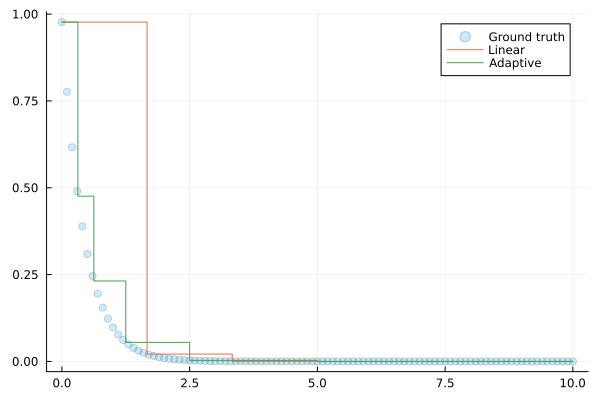

In [11]:
function example_function(x)
   return 10^-(x + 0.01)
end

range_end = 10
x_points = adaptive_sampling(example_function, 0.0001, range_end, 0.1, 4)
N = length(x_points)

x = 0:0.1:range_end
y = [example_function(x) for x in x]
scatter(x,y,  alpha = 0.2, label="Ground truth")

x = collect(range(0, range_end, length = N))
y = [example_function(x+0.0001) for x in x]
plot!(x,y, seriestype=:steppost, label="Linear")

x = x_points
y = [example_function(x) for x in x]
plot!(x,y, seriestype=:steppost, label="Adaptive")